In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import torch

# Rand reps, model init fixed

In [2]:
import sys
sys.path.append('../../')

import denn.utils as ut

In [4]:
# folder = lambda i: f"/Users/dylanrandle/Downloads/POS_run_gan_053020_seed{i}/val_mse.npy"
# gan_reps = []
# for i in range(5):
#     gan_reps.append(np.load(folder(i)))
# gan_reps = np.vstack(gan_reps)

In [3]:
# gan_reps = np.load('/Users/dylanrandle/Downloads/pos_reps_052620_gan.npy')

gan_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_gan.npy')
kept_runs = [2,5,6,7,9]
gan_reps = gan_reps[kept_runs, :]

l2_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_L2.npy')

l1_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_L1.npy')

huber_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/aca/aca_rand_reps_huber.npy')

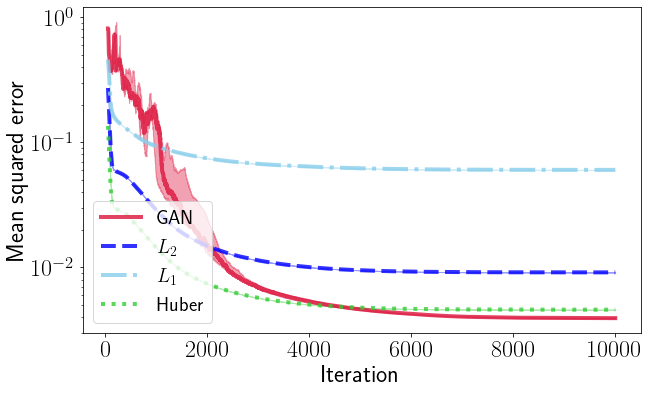

In [5]:
arrs_dict = {"GAN": gan_reps, 
             "$L_2$": l2_reps,
             "$L_1$": l1_reps, 
             "Huber": huber_reps,
#              "RK4": mse*np.ones_like(huber_reps)
            }
ut.plot_reps_results(arrs_dict, fname="aca_rand_reps.png",
                     window=50, figsize=(10,6), pctiles=(25,75), linewidth=4)

In [11]:
print(f"L1 Min: {np.min(l1_reps)}")
print(f"L2 Min: {np.min(l2_reps)}")
print(f"Huber Min: {np.min(huber_reps)}")
print(f"GAN Min: {np.min(gan_reps)}")

L1 Min: 0.06020234525203705
L2 Min: 0.009126380197829584
Huber Min: 0.004592604979635454
GAN Min: 0.0038728368868653114


# Finite Diff

In [2]:
def get_exact_dt(delta_x, delta_t, dx, N):
    dt = ((delta_x*delta_t + delta_t*dx) / (N*dx - delta_x - dx))
    return dt

In [19]:
xmin, xmax = 0, 2*np.pi
tmin, tmax = 0, 5.0
delta_x = xmax - xmin
delta_t = tmax - tmin

min_diff = np.inf
best_dx, best_dt = None, None

for denom in range(2,100):
    dx = 1 / denom
    dt = get_exact_dt(delta_x=delta_x, delta_t=delta_t, dx=dx, N=65**2)

    nx = int((delta_x)/dx) + 1
    nt = int((delta_t)/dt) + 1
    
    diff = np.abs(nx*nt - 65**2)
    if diff < min_diff:
        min_diff = diff
        best_dx, best_dt = dx, dt
        
nx = int((delta_x)/best_dx) + 1
nt = int((delta_t)/best_dt) + 1
print(nx*nt, 65**2)

4218 4225


In [20]:
epsilon=0.001
u = np.zeros((nx,nt))

# initial condition
def initial_cond(x):
    val = 0.25*np.sin(x)
    return val

for x in range(0,nx):
    u[x,0]=initial_cond(xmin+x*best_dx)

#simulate dynamics
for t in range(0,nt-1):
    for x in range(1,nx-1):
        u[x,t+1] = epsilon*((u[x-1,t]-2*u[x,t]+u[x+1,t]) / (best_dx**2))*best_dt + u[x,t]*best_dt - best_dt*(u[x,t])**3 + u[x,t]

In [21]:
x = np.linspace(xmin, xmax, nx)
t = np.linspace(tmin, tmax, nt)
xx, tt = np.meshgrid(x, t)

In [22]:
xx.shape, tt.shape, u.shape

((37, 114), (37, 114), (114, 37))

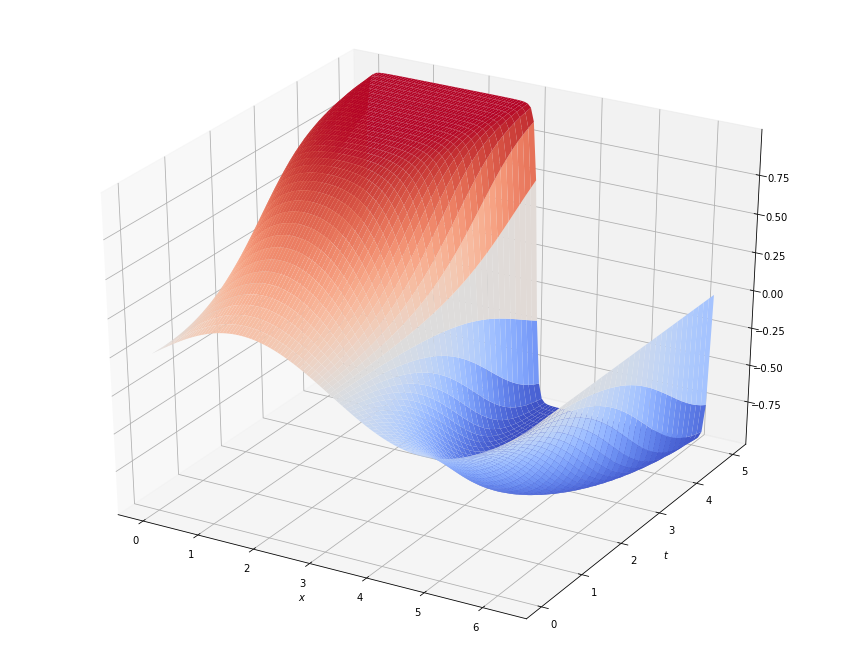

In [24]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(xx, tt, u.T, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
plt.show()

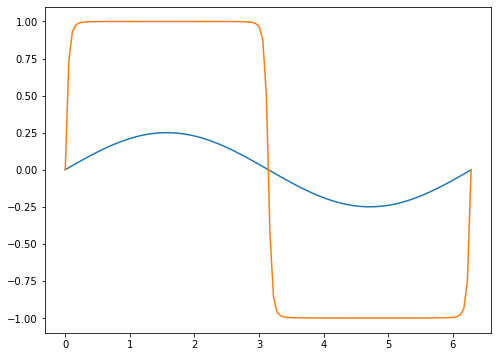

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, u[:,0])
ax.plot(x, u[:,-1])
plt.show()

# Fast Fourier Transform

In [26]:
def fft_allen_cahn(x, t, epsilon):
    
    nx, nt = len(x), len(t)
    dt=0.001
    v=0.25*np.sin(x)
    k = np.arange(0,int(nx/2))
    k = np.append(k, 0)
    k = np.concatenate((k, np.arange(-nx/2+1,0)))
    k = k*1j
    k2=np.real(np.square(k))
    tmax=np.max(t)
    tplot=tmax/(nt-1)
    plotgap=int(np.round(tplot/dt))
    nplots=int(np.round(tmax/tplot))
    data = np.zeros((nplots+1,nx))
    data[0,:] = v

    for i in np.arange(1,nplots+1):
        for n in np.arange(1,plotgap+1):
            v_hat = np.fft.fft(v) # converts to Fourier space
            vv = np.power(v, 3) # computes nonlinear term in real space
            vv = np.fft.fft(vv) # converts nonlinear term to Fourier space
            num, denom = v_hat*(1/dt+1)-vv, 1/dt-k2*epsilon
            v_hat = np.divide(num, denom) # Implicit / Explicit
            v = np.fft.ifft(v_hat)
        data[i,:] = np.real(v)
    
    return data

In [27]:
x_fine = np.linspace(xmin,xmax,(nx-1)*16+1)
y_fine = np.linspace(tmin,tmax,nt)
x_fine_grid, y_fine_grid = np.meshgrid(x_fine, y_fine)
u_fine = fft_allen_cahn(x_fine, y_fine, epsilon)

In [28]:
x_fine_grid.shape, y_fine_grid.shape, u_fine.shape

((37, 1809), (37, 1809), (37, 1809))

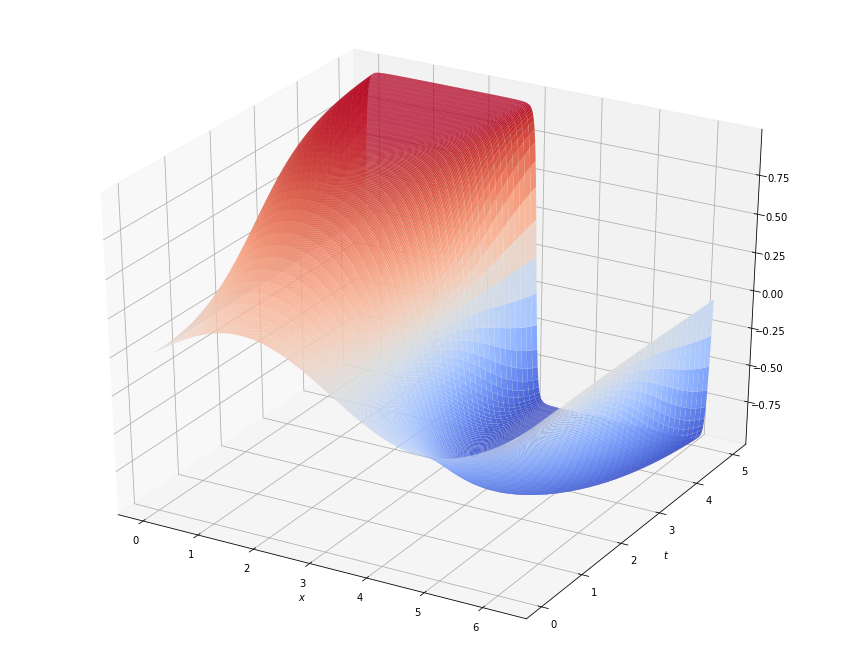

In [30]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(projection="3d")
ax.plot_surface(x_fine_grid, y_fine_grid, u_fine, cmap=cm.coolwarm, rcount=500, ccount=500)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
plt.show()

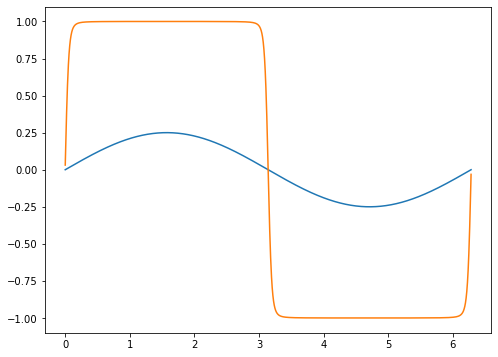

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_fine, u_fine.T[:,0])
ax.plot(x_fine, u_fine.T[:,-1])
plt.show()

In [32]:
u.T.shape, u_fine[:,::16].shape

((37, 114), (37, 114))

In [33]:
print(x_fine[::16])
print(x)

[0.         0.05560341 0.11120682 0.16681023 0.22241364 0.27801705
 0.33362046 0.38922387 0.44482728 0.50043069 0.5560341  0.61163751
 0.66724092 0.72284433 0.77844774 0.83405115 0.88965456 0.94525797
 1.00086138 1.05646479 1.1120682  1.16767161 1.22327502 1.27887843
 1.33448184 1.39008524 1.44568865 1.50129206 1.55689547 1.61249888
 1.66810229 1.7237057  1.77930911 1.83491252 1.89051593 1.94611934
 2.00172275 2.05732616 2.11292957 2.16853298 2.22413639 2.2797398
 2.33534321 2.39094662 2.44655003 2.50215344 2.55775685 2.61336026
 2.66896367 2.72456708 2.78017049 2.8357739  2.89137731 2.94698072
 3.00258413 3.05818754 3.11379095 3.16939436 3.22499777 3.28060118
 3.33620459 3.391808   3.44741141 3.50301482 3.55861823 3.61422164
 3.66982505 3.72542846 3.78103187 3.83663528 3.89223869 3.9478421
 4.00344551 4.05904892 4.11465233 4.17025573 4.22585914 4.28146255
 4.33706596 4.39266937 4.44827278 4.50387619 4.5594796  4.61508301
 4.67068642 4.72628983 4.78189324 4.83749665 4.89310006 4.948703

In [34]:
np.mean((u.T - u_fine[:,::16])**2)

0.000246574963361254